### Compare feature distribution by AKI group
> The groups are: **Control group**, **AKI stage 1 group by level**,
**AKI stage 1 group by rate**, **AKI stage 2 group**, **AKI stage 3 group**

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
fileDir = os.path.dirname('__file__')
already_converted = False

#### Load I/O dataframe from ISM, STM, Banner

In [3]:
f_ioism_aki = os.path.join(fileDir, 'io_ism5', 
                           'ism_onset_io_tlag006_twin006_aki.pkl')
f_ioism_con = os.path.join(fileDir, 'io_ism5',
                           'ism_onset_io_tlag006_twin006_con.pkl')

In [4]:
f_iostm_aki = os.path.join(fileDir, 'io_stm5',
                           'stm_onset_io_tlag006_twin006_aki.pkl')
f_iostm_con = os.path.join(fileDir, 'io_stm5', 
                           'stm_onset_io_tlag006_twin006_con.pkl')

In [5]:
f_iobanner_aki = os.path.join(fileDir, 'io_banner4',
                              'banner_onset_io_tlag006_twin006_aki.pkl')
f_iobanner_con = os.path.join(fileDir, 'io_banner4', 
                              'banner_onset_io_tlag006_twin006_con.pkl')

In [6]:
io_ism_aki = pd.read_pickle(f_ioism_aki)
io_ism_con = pd.read_pickle(f_ioism_con)
io_stm_aki = pd.read_pickle(f_iostm_aki)
io_stm_con = pd.read_pickle(f_iostm_con)
io_banner_aki = pd.read_pickle(f_iobanner_aki)
io_banner_con = pd.read_pickle(f_iobanner_con)

#### Load creatinine dataframe from ISM and STM

In [7]:
f_cr_ism = os.path.join(fileDir, 'item_df_ism', 'ism_creatinine_df.pkl')
f_cr_stm = os.path.join(fileDir, 'item_df_stm', 'stm_creatinine_df.pkl')
f_cr_banner = os.path.join(fileDir, 'item_df_banner', 'banner_creatinine_df.pkl')

In [8]:
cr_ism = pd.read_pickle(f_cr_ism)
cr_stm = pd.read_pickle(f_cr_stm)
cr_banner = pd.read_pickle(f_cr_banner)

In [12]:
cr_banner.rename(columns={'ENCNTR_ID': 'encounter_id', 
                          'EVENT_END_DT_TM': 'charttime',
                          'RESULT_VAL_num': 'value'                          
                         }, inplace=True)

In [13]:
# Get encounter_id list from each group
ceid_ism_aki = io_ism_aki.encounter_id.unique().tolist()
ceid_ism_con = io_ism_con.encounter_id.unique().tolist()
ceid_stm_aki = io_stm_aki.encounter_id.unique().tolist()
ceid_stm_con = io_stm_con.encounter_id.unique().tolist()
ceid_banner_aki = io_banner_aki.encounter_id.unique().tolist()
ceid_banner_con = io_banner_con.encounter_id.unique().tolist()

#### Tag AKI type
> Tag each encounter of I/O dataframe by either **'level'**, **'rate'**, or **None**

In [10]:
def tagAKIType(group, db_name):
    mask = (group.charttime==group.reftime.unique()[0])
    if db_name=='ism':
        scr = group.value1
    else:
        scr = group.value
        
    if np.sum(mask)==0:
        group['AKItype'] = None
    elif ((group.AKI_stage[mask]==1.0).tolist()[0] 
          & (group.scr_rate[mask]>=0.3).tolist()[0] 
          & ((scr[mask]).tolist()[0] < group.bs_scr.unique()[0]*1.5)):
        group['AKItype'] = 'rate'
    elif (group.AKI_stage[mask]>0.0).tolist()[0]:
        group['AKItype'] = 'level'
    else:
        group['AKItype'] = None
    return group

In [14]:
def addAKItype(io_df, cr_df):
    for idx, row in io_df.iterrows():
        cr_idx = cr_df.index[cr_df.encounter_id==row.encounter_id]
        io_df.loc[idx, 'AKItype'] = cr_df.AKItype[cr_idx].unique()[0]
    return io_df

In [15]:
cr_ism = cr_ism.groupby('encounter_id').apply(tagAKIType,'ism')
cr_stm = cr_stm.groupby('encounter_id').apply(tagAKIType,'stm')
cr_banner = cr_banner.groupby('encounter_id').apply(tagAKIType,'stm')

In [12]:
# AKItype_all = np.hstack(cr_ism.groupby('encounter_id')['AKItype'].unique())
# type_none = [type is None for type in AKItype_all ]
# type_aki = [type is not None for type in AKItype_all ]

# print(np.sum(type_none))
# print(np.sum(type_aki))

In [16]:
io_ism_aki = addAKItype(io_ism_aki, cr_ism)
io_ism_con = addAKItype(io_ism_con, cr_ism)

io_stm_aki = addAKItype(io_stm_aki, cr_stm)
io_stm_con = addAKItype(io_stm_con, cr_stm)

io_banner_aki = addAKItype(io_banner_aki, cr_banner)
io_banner_con = addAKItype(io_banner_con, cr_banner)

In [17]:
io_ism = pd.concat([io_ism_aki, io_ism_con], axis=0)
io_stm = pd.concat([io_stm_aki, io_stm_con], axis=0)
io_banner = pd.concat([io_banner_aki, io_banner_con], axis=0)

#### Get encounter lists for each AKI type

In [18]:
def getEncountersByType(io_df):
#     type_rate = [type=='rate' for type in io_df.AKItype ]
#     type_level = [type=='level' for type in io_df.AKItype ]
#     type_none = [pd.isnull(type) for type in io_df.AKItype ]
    enc_rate = io_df.encounter_id[io_df.AKItype=='rate'].tolist()
    enc_level = io_df.encounter_id[io_df.AKItype=='level'].tolist()
    enc_none = io_df.encounter_id[pd.isnull(io_df.AKItype)].tolist()
    nb_rate = len(enc_rate)
    nb_level = len(enc_level)
    nb_none = len(enc_none)
    nb_total = nb_level + nb_rate + nb_none
    pc_rate = nb_rate/float(nb_total)*100
    pc_level = nb_level/float(nb_total)*100
    print('Number of AKI encounters by rate: {}({})'.format(nb_rate, np.round(pc_rate)))
    print('Number of AKI encounters by level: {}({})'.format(nb_level, np.round(pc_level)))    
    print('Number of stable encounters: {}'.format(nb_none))    
    print('Number of Total encounters: {}'.format(nb_total))
    
    return (enc_rate, enc_level, enc_none)

In [19]:
print(' ISM')
enc_ism_rate, enc_ism_level, enc_ism_none = getEncountersByType(io_ism)

print('\n STM')
enc_stm_rate, enc_stm_level, enc_stm_none = getEncountersByType(io_stm)

print('\n Banner')
enc_banner_rate, enc_banner_level, enc_banner_none = getEncountersByType(io_banner)

 ISM
Number of AKI encounters by rate: 467(6.0)
Number of AKI encounters by level: 296(4.0)
Number of stable encounters: 7341
Number of Total encounters: 8104

 STM
Number of AKI encounters by rate: 45(3.0)
Number of AKI encounters by level: 118(9.0)
Number of stable encounters: 1225
Number of Total encounters: 1388

 Banner
Number of AKI encounters by rate: 19(1.0)
Number of AKI encounters by level: 43(3.0)
Number of stable encounters: 1593
Number of Total encounters: 1655


In [21]:
37/1655.

0.022356495468277945

In [17]:
# nb_type_rate = np.sum(type_rate)
# nb_type_level = np.sum(type_level)
# nb_type_all = nb_type_rate + nb_type_level
# nb_type_none = np.sum(type_none)
# print('Number of AKI encounters by rate: {}'.format(nb_type_rate))
# print('Number of AKI encounters by level: {}'.format(nb_type_level))
# print('Number of AKI encounters: {}'.format(nb_type_all))
# print('Number of stable encounters: {}'.format(nb_type_none))

In [18]:
def plotHistogram(series11, series12, series13, 
                  series21, series22, series23, ft_name, figdir=None):
    series_all = series11.append(series12)
    series_all = series_all.append(series13)
    series_all = series_all.append(series21)
    series_all = series_all.append(series22)
    series_all = series_all.append(series23)
    series_all = series_all[~pd.isnull(series_all)]
#     if ft_name=='nsbp_last':
#         stop
#     print(series_all.min())
#     print(series_all.max())
    bins=np.linspace(series_all.min(), series_all.max(), 100)
    data_list = [[series11, series12, series13], 
                 [series21, series22, series23]]
    print(ft_name)
    print('ISM y=0:{} +- {}'.format(np.round(series11.mean()*100)/100., np.round(series11.std()*100)/100.))
    print('ISM y=1 (rate):{} +- {}'.format(np.round(series12.mean()*100)/100., np.round(series12.std()*100)/100.))
    print('ISM:y=1 (level): {} +- {}'.format(np.round(series13.mean()*100)/100., np.round(series13.std()*100)/100.))
    
    print('STM y=0:{} +- {}'.format(np.round(series21.mean()*100)/100., np.round(series21.std()*100)/100.))
    print('STM y=1 (rate):{} +- {}'.format(np.round(series22.mean()*100)/100., np.round(series22.std()*100)/100.))
    print('STM y=1 (level):{} +- {}'.format(np.round(series23.mean()*100)/100., np.round(series23.std()*100)/100.))
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(13, 7))
    title_strs = ['CHLA', 'St.Mary']
    for ax, data, title_str in zip(axs.reshape(-1), data_list, title_strs):
        plt.sca(ax)
        plt.hold(True)
        nmv0 = np.sum(pd.isnull(data[0]))
        ndp0 = len(data[0])
        prv0 = float(nmv0)/float(ndp0)*100
        nmv1 = np.sum(pd.isnull(data[1]))
        ndp1 = len(data[1])
        prv1 = float(nmv1)/float(ndp1)*100
        nmv2 = np.sum(pd.isnull(data[2]))
        ndp2 = len(data[2])
        prv2 = float(nmv2)/float(ndp2)*100
        
        plt.hist(data[0][~pd.isnull(data[0])], bins, normed=True, alpha=0.2, 
                 label='y=0 ; NMV={}/{} ({})'.format(nmv0, ndp0, np.round(prv0)))
        plt.hist(data[1][~pd.isnull(data[1])], bins, normed=True, alpha=0.2, 
                 label='y=1 (rate) ; NMV={}/{} ({})'.format(nmv1, ndp1, np.round(prv1)))
        plt.hist(data[2][~pd.isnull(data[2])], bins, normed=True, alpha=0.2, 
                 label='y=1 (level) ; NMV={}/{} ({})'.format(nmv2, ndp2, np.round(prv2)))
        plt.legend(loc='upper right')
        plt.title(title_str)
    plt.suptitle(ft_name.replace('_', ' '), fontsize=20)
    plt.show()
    if figdir is not None:
        figname = os.path.join(figdir, '{}.png'.format(ft_name))
        fig.savefig(figname)
        

In [19]:
fts = ['age', 'nsbp_last', 'ndbp_last', 'hr_last', 'spo2_last', 
       'hemoglobin_last', 'temperature_last', 'wbc_last', 'platelet_last', 
       'albumin_last', 'urine_last', 'potassium_last', 'glucose_last', 
       'creatinine_last', 'lactic_acid_last', 'osi_last', 'si_last', 
       'oi_last']

In [20]:
if not already_converted:
    io_stm['albumin_last'] = io_stm['albumin_last']*0.1

    io_stm['glucose_last'] = io_stm['glucose_last']*18.0182

    io_stm['lactic_acid_last'] = io_stm['lactic_acid_last']*9.009
    already_converted = True

age
ISM y=0:6.39 +- 6.1
ISM y=1 (rate):7.41 +- 6.82
ISM:y=1 (level): 5.04 +- 6.24
STM y=0:4.0 +- 4.58
STM y=1 (rate):6.82 +- 5.04
STM y=1 (level):3.91 +- 4.5


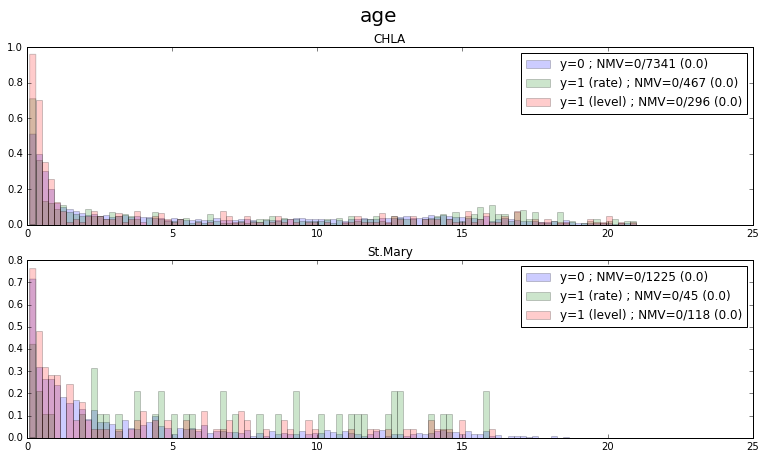

nsbp_last
ISM y=0:101.61 +- 17.33
ISM y=1 (rate):97.93 +- 21.27
ISM:y=1 (level): 91.3 +- 23.67
STM y=0:97.83 +- 19.91
STM y=1 (rate):94.11 +- 18.9
STM y=1 (level):92.09 +- 21.66


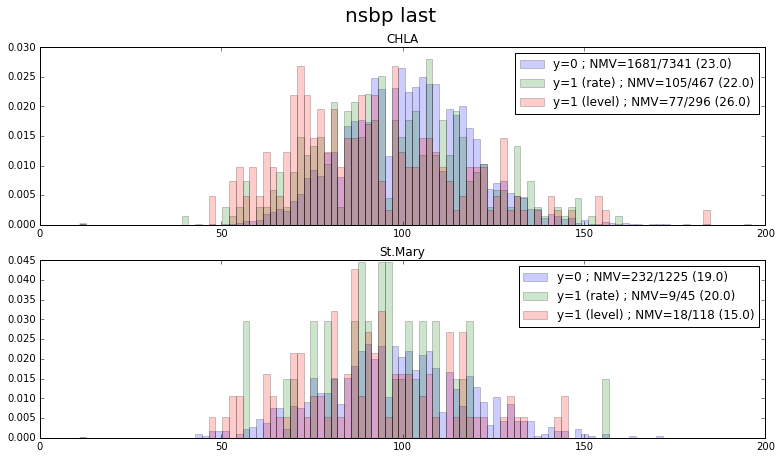

ndbp_last
ISM y=0:50.98 +- 13.44
ISM y=1 (rate):49.16 +- 16.49
ISM:y=1 (level): 46.06 +- 16.94
STM y=0:47.38 +- 17.71
STM y=1 (rate):40.06 +- 13.93
STM y=1 (level):43.14 +- 16.14


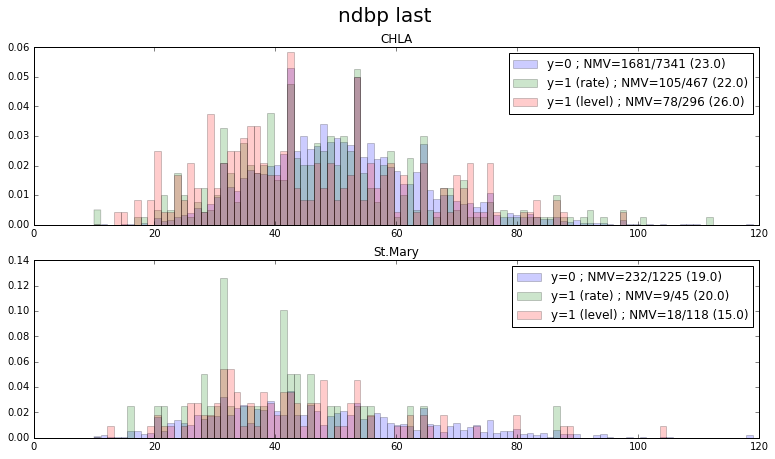

hr_last
ISM y=0:117.04 +- 26.84
ISM y=1 (rate):126.63 +- 27.64
ISM:y=1 (level): 137.96 +- 28.39
STM y=0:123.79 +- 24.2
STM y=1 (rate):118.55 +- 26.85
STM y=1 (level):126.89 +- 23.93


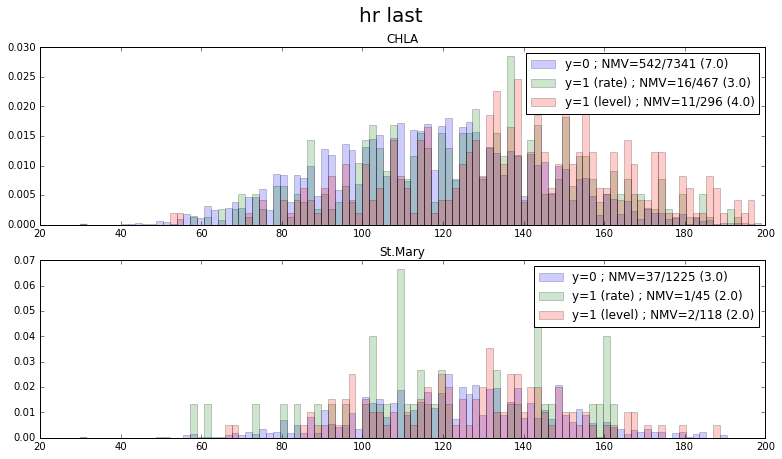

spo2_last
ISM y=0:95.76 +- 4.91
ISM y=1 (rate):93.95 +- 6.61
ISM:y=1 (level): 92.43 +- 7.88
STM y=0:96.5 +- 2.56
STM y=1 (rate):94.95 +- 2.67
STM y=1 (level):94.88 +- 3.63


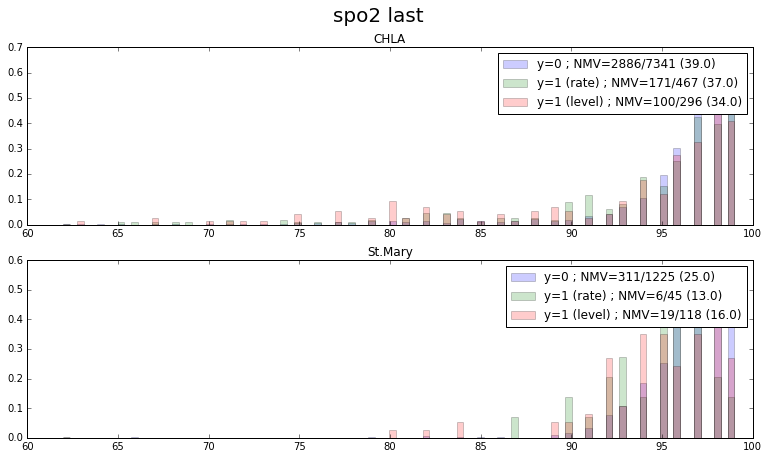

hemoglobin_last
ISM y=0:11.17 +- 2.25
ISM y=1 (rate):11.47 +- 2.17
ISM:y=1 (level): 12.16 +- 3.07
STM y=0:9.69 +- 1.61
STM y=1 (rate):10.2 +- 1.23
STM y=1 (level):10.12 +- 1.78


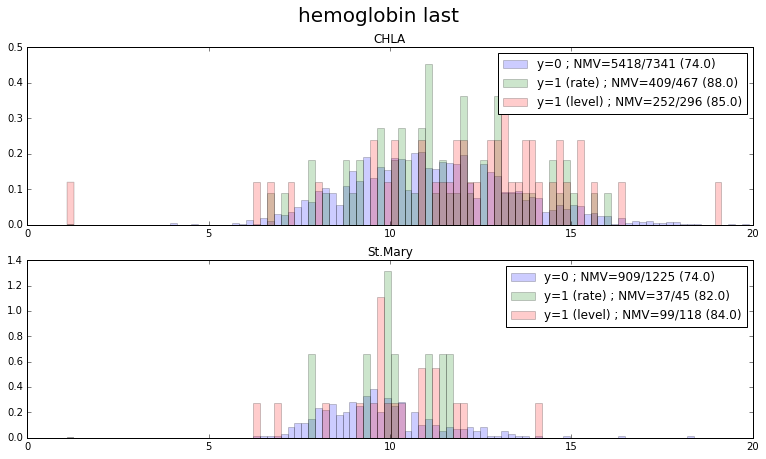

temperature_last
ISM y=0:37.2 +- 0.62
ISM y=1 (rate):37.21 +- 0.83
ISM:y=1 (level): 37.25 +- 0.88
STM y=0:37.21 +- 0.7
STM y=1 (rate):37.23 +- 0.9
STM y=1 (level):37.18 +- 0.97


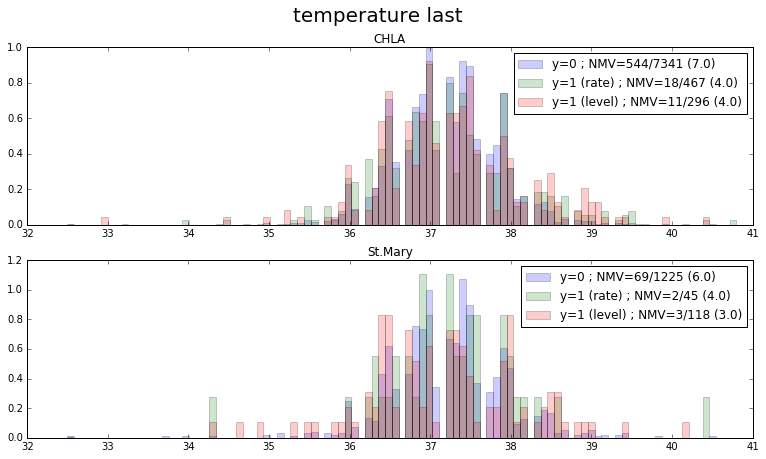

wbc_last
ISM y=0:12.23 +- 5.54
ISM y=1 (rate):11.89 +- 7.43
ISM:y=1 (level): 11.64 +- 7.8
STM y=0:10.99 +- 7.1
STM y=1 (rate):7.83 +- 4.77
STM y=1 (level):7.58 +- 4.6


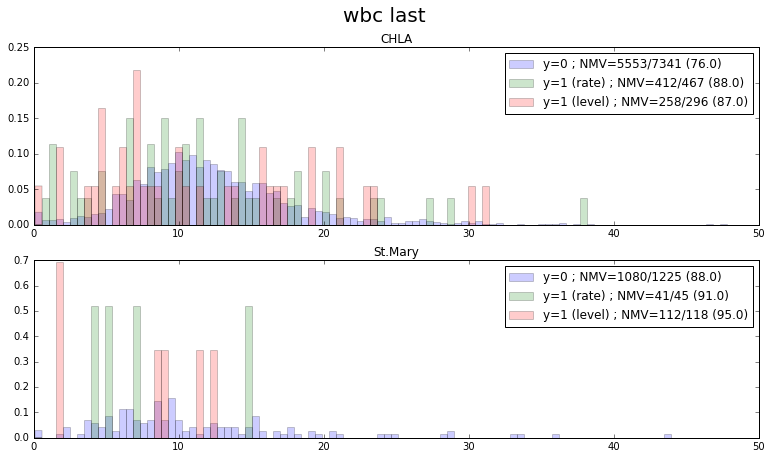

platelet_last
ISM y=0:198.38 +- 99.61
ISM y=1 (rate):224.83 +- 165.19
ISM:y=1 (level): 125.76 +- 98.94
STM y=0:271.5 +- 138.95
STM y=1 (rate):188.38 +- 109.89
STM y=1 (level):195.05 +- 145.52


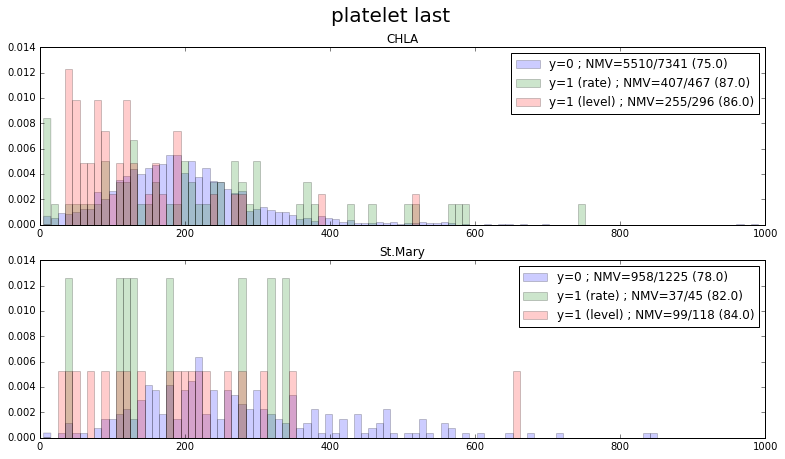

albumin_last
ISM y=0:2.95 +- 0.7
ISM y=1 (rate):2.97 +- 0.71
ISM:y=1 (level): 2.76 +- 0.85
STM y=0:2.86 +- 0.57
STM y=1 (rate):3.25 +- 0.49
STM y=1 (level):2.78 +- 0.59


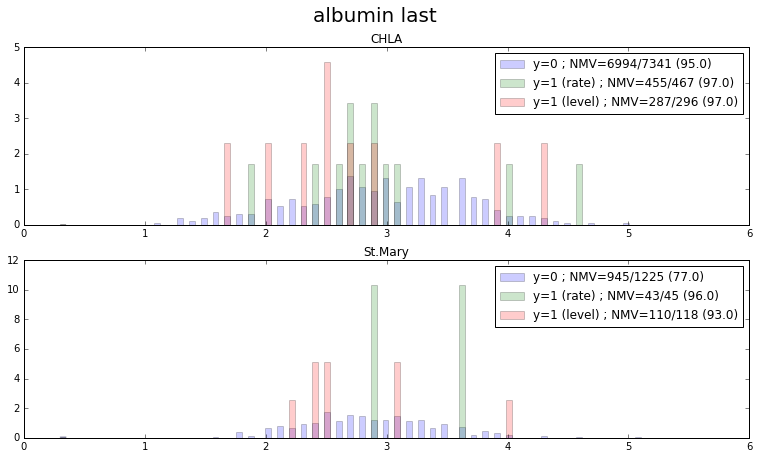

urine_last
ISM y=0:3.07 +- 2.6
ISM y=1 (rate):3.07 +- 2.68
ISM:y=1 (level): 2.9 +- 3.17
STM y=0:3.01 +- 2.26
STM y=1 (rate):2.14 +- 1.63
STM y=1 (level):3.2 +- 3.11


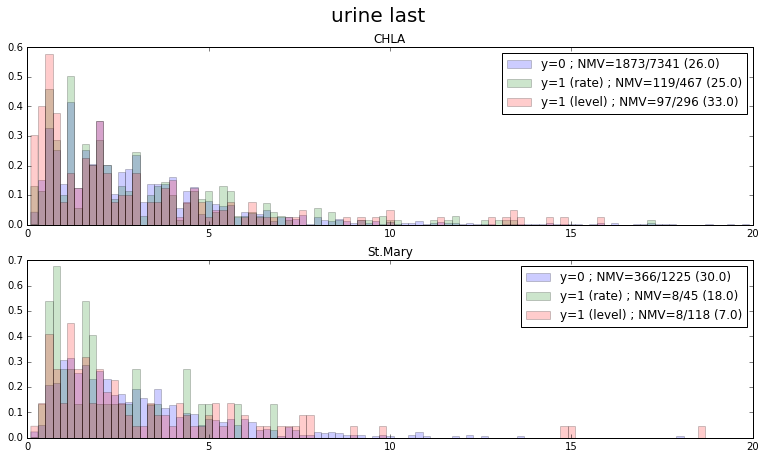

potassium_last
ISM y=0:3.9 +- 0.57
ISM y=1 (rate):3.87 +- 0.97
ISM:y=1 (level): 4.26 +- 1.19
STM y=0:4.02 +- 0.62
STM y=1 (rate):3.86 +- 0.62
STM y=1 (level):4.23 +- 0.75


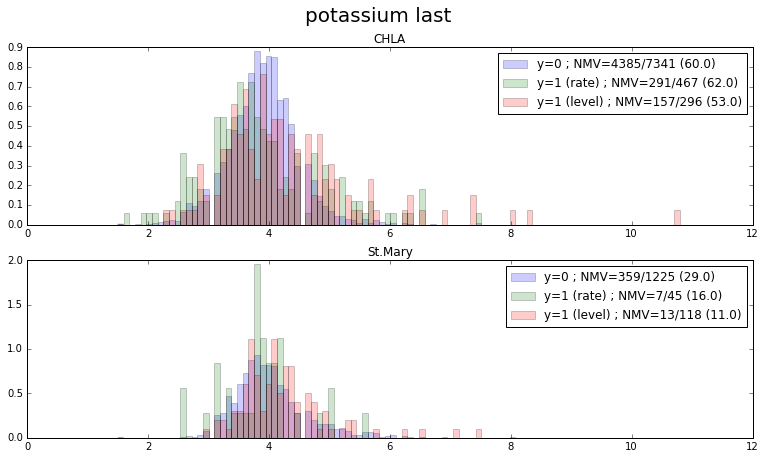

glucose_last
ISM y=0:125.48 +- 45.11
ISM y=1 (rate):139.07 +- 69.75
ISM:y=1 (level): 135.33 +- 89.1
STM y=0:122.34 +- 45.14
STM y=1 (rate):137.79 +- 55.28
STM y=1 (level):133.07 +- 52.74


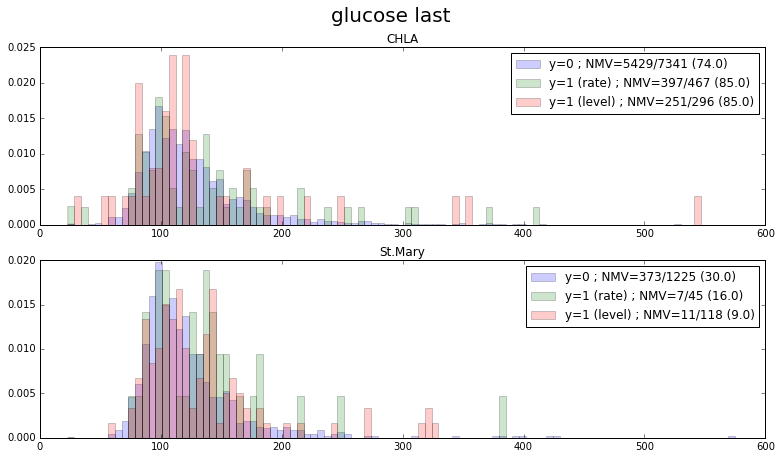

creatinine_last
ISM y=0:0.42 +- 0.18
ISM y=1 (rate):0.57 +- 0.32
ISM:y=1 (level): 0.89 +- 0.36
STM y=0:0.46 +- 0.14
STM y=1 (rate):0.6 +- 0.08
STM y=1 (level):0.77 +- 0.26


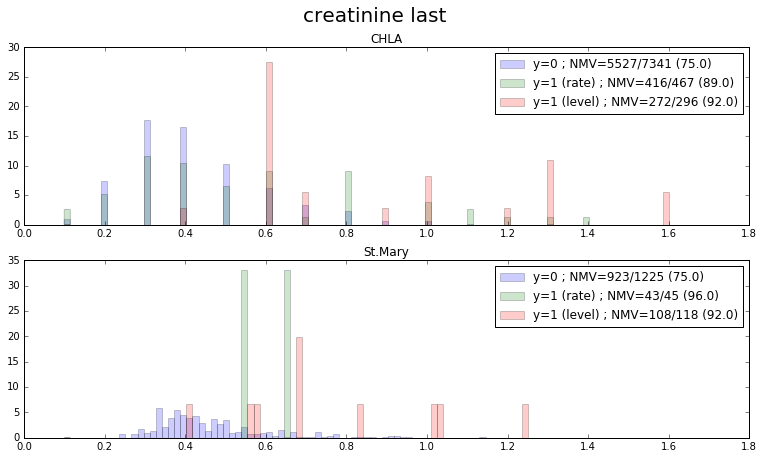

lactic_acid_last
ISM y=0:21.13 +- 17.14
ISM y=1 (rate):34.3 +- 27.35
ISM:y=1 (level): 50.69 +- 33.38
STM y=0:9.3 +- 6.91
STM y=1 (rate):13.41 +- 7.73
STM y=1 (level):15.32 +- 16.94


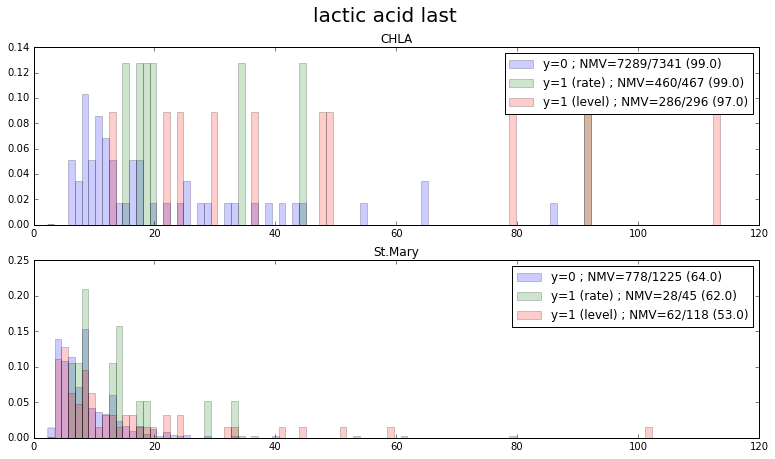

osi_last
ISM y=0:4.21 +- 4.16
ISM y=1 (rate):7.17 +- 6.72
ISM:y=1 (level): 7.98 +- 7.44
STM y=0:3.53 +- 2.66
STM y=1 (rate):5.42 +- 3.68
STM y=1 (level):4.64 +- 3.2


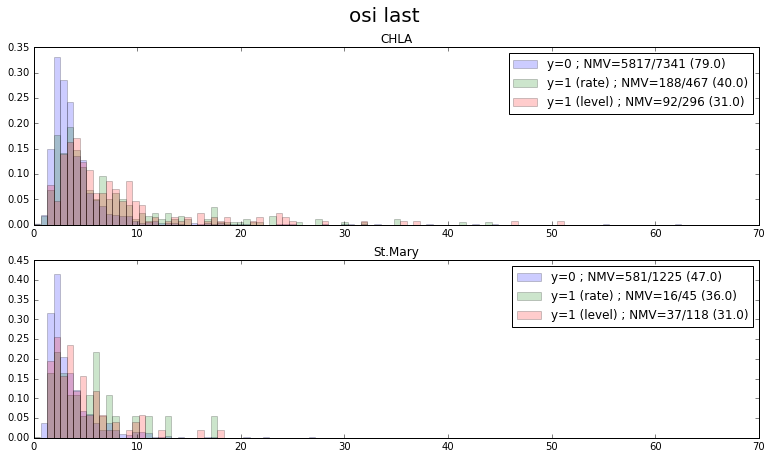

si_last
ISM y=0:1.2 +- 0.41
ISM y=1 (rate):1.38 +- 0.53
ISM:y=1 (level): 1.64 +- 0.64
STM y=0:1.34 +- 0.43
STM y=1 (rate):1.35 +- 0.54
STM y=1 (level):1.47 +- 0.49


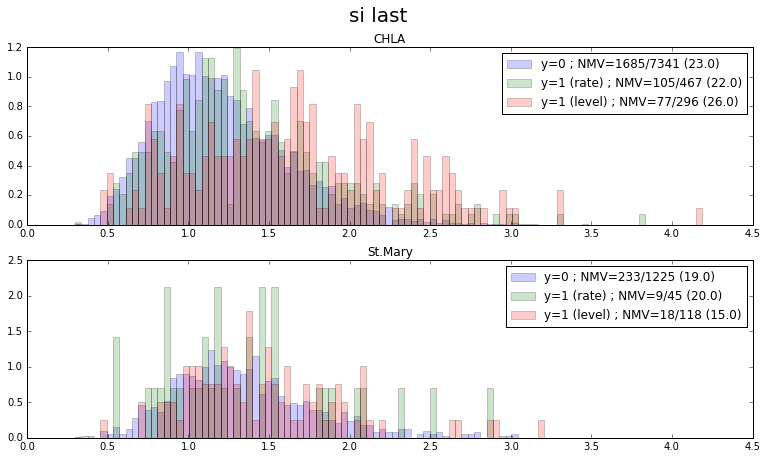

oi_last
ISM y=0:4.16 +- 5.62
ISM y=1 (rate):7.65 +- 10.6
ISM:y=1 (level): 10.41 +- 11.96
STM y=0:3.74 +- 3.4
STM y=1 (rate):6.67 +- 6.51
STM y=1 (level):5.05 +- 4.99


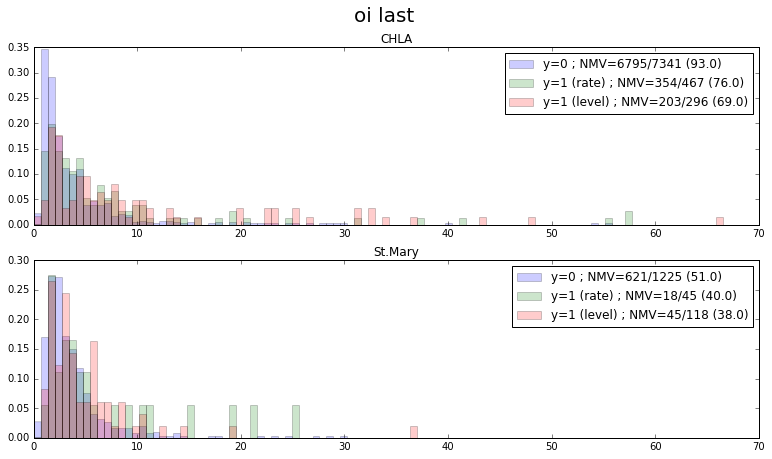

In [21]:
figdir = os.path.join(fileDir, 'distribution_compare_by_AKItype')
for ft in fts:
    s_ism_con = io_ism.loc[np.in1d(io_ism.encounter_id, 
                                   enc_ism_none),
                           ft]
    s_ism_aki_rate = io_ism.loc[np.in1d(io_ism.encounter_id, 
                                        enc_ism_rate),
                                ft]
    s_ism_aki_level = io_ism.loc[np.in1d(io_ism.encounter_id, 
                                        enc_ism_level),
                                ft]
    s_stm_con = io_stm.loc[np.in1d(io_stm.encounter_id, 
                                   enc_stm_none),
                           ft]
    s_stm_aki_rate = io_stm.loc[np.in1d(io_stm.encounter_id, 
                                        enc_stm_rate),
                                ft]
    s_stm_aki_level = io_stm.loc[np.in1d(io_stm.encounter_id, 
                                        enc_stm_level),
                                ft]
    if ft=='age':
        s_ism_con = s_ism_con/365.
        s_ism_aki_rate = s_ism_aki_rate/365.
        s_ism_aki_level = s_ism_aki_level/365.
        s_stm_con = s_stm_con/365.
        s_stm_aki_rate = s_stm_aki_rate/365.
        s_stm_aki_level = s_stm_aki_level/365.
    
#     plotHistogram1(s_ism_con, s_ism_aki, ft, figdir=figdir)
    plotHistogram(s_ism_con, s_ism_aki_rate, s_ism_aki_level, 
                  s_stm_con, s_stm_aki_rate, s_stm_aki_level, ft, figdir=figdir)
#     plotHistogram(s_ism_con, s_ism_aki, s_stm_con, s_stm_aki, ft, figdir=figdir)

In [25]:
from scipy import io
import pickle

In [26]:
f_ism = os.path.join(fileDir, 'io_ism5', 'ceid_group_ism.pkl')
f_stm = os.path.join(fileDir, 'io_stm5', 'ceid_group_stm.pkl')


ceid_group_ism = {'ceidAKIRate': enc_ism_rate, 'ceidAKILevel': enc_ism_level, 'ceidStable': enc_ism_none}
ceid_group_stm = {'ceidAKIRate': enc_stm_rate, 'ceidAKILevel': enc_stm_level, 'ceidStable': enc_stm_none}

pickle.dump(ceid_group_ism, open(f_ism, 'wb'))
pickle.dump(ceid_group_stm, open(f_stm, 'wb'))

io.savemat(f_ism[:-3]+'mat', ceid_group_ism)
io.savemat(f_stm[:-3]+'mat', ceid_group_stm)